In [34]:
client_id = '50cad4a8-6d76-4957-8aeb-de5625282773'
client_secret = 'o5ie4wUubGxYblLMLDuee1CRF3eMBMTs'

In [35]:
#Get token
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/auth/realms/main/protocol/openid-connect/token',
                          client_secret=client_secret, include_client_id=True)

# All requests using this session will have an access token automatically added
resp = oauth.get("https://services.sentinel-hub.com/configuration/v1/wms/instances")
print(resp.content)
print(token.get('access_token'))

b'[{"@id":"https://services.sentinel-hub.com/configuration/v1/wms/instances/2191858f-748e-44d5-83ec-1929c75e89fd","id":"2191858f-748e-44d5-83ec-1929c75e89fd","name":"Australia Fire","domainAccountId":"c04ddd9e-6f6c-4ca3-9b38-4bd65652651f","additionalData":{"showWarnings":true,"showLogo":false,"imageQuality":100},"created":"2024-06-08T12:34:40.811483Z","lastUpdated":"2024-06-08T12:35:17.223030Z","layers":{"@id":"https://services.sentinel-hub.com/configuration/v1/wms/instances/2191858f-748e-44d5-83ec-1929c75e89fd/layers"}},{"@id":"https://services.sentinel-hub.com/configuration/v1/wms/instances/c0204f08-0026-4f7f-8652-05f4d07e9286","id":"c0204f08-0026-4f7f-8652-05f4d07e9286","name":"Simple WMS template","domainAccountId":"c04ddd9e-6f6c-4ca3-9b38-4bd65652651f","additionalData":{"showWarnings":true,"showLogo":true,"imageQuality":90},"created":"2024-05-29T12:41:01.300209Z","lastUpdated":"2024-05-29T12:41:01.300209Z","layers":{"@id":"https://services.sentinel-hub.com/configuration/v1/wms/ins

Get the tiff image of New South Wales from 2019.08.01 to 2019.09.30

In [36]:
import requests
import json


# BBox of New South Wales, Australia
bbox = [140.9993, -37.5050, 159.1056, -28.1570]

# Define the evalscript including cloud filtering
evalscript = """
//VERSION=3
function setup() {
    return {
        input: ["B08", "B04", "B03", "SCL"],
        output: { bands: 4 }
    };
}

function evaluatePixel(sample) {
    if (sample.SCL == 3 || sample.SCL == 8 || sample.SCL == 9 || sample.SCL == 10) {
        // Return transparent for clouds, shadows, and snow
        return [0, 0, 0, 0];
    }
    return [sample.B08, sample.B04, sample.B03, 1];
}
"""

# Define the request body including the evalscript
request_body = {
    "input": {
        "bounds": {
            "bbox": bbox
        },
        "data": [
            {
                "type": "S2L2A",
                "dataFilter": {
                    "timeRange": {
                        "from": "2019-08-01T00:00:00Z",
                        "to": "2019-09-30T23:59:59Z"
                    },
                    "maxCloudCoverage": 20  # Set maximum cloud coverage to 20%
                }
            }
        ]
    },
    "output": {
        "width": 2048,  # width of the output image
        "height": 2048,  # height of the output image
        "responses": [
            {
                "identifier": "default",
                "format": {
                    "type": "image/tiff"
                }
            }
        ]
    },
    "evalscript": evalscript
}

# Send the POST request with the request body
response = requests.post(
    'https://services.sentinel-hub.com/api/v1/process',
    headers={
        'Authorization': f'Bearer {my_token}',
        'Content-Type': 'application/json'
    },
    data=json.dumps(request_body)
)

# Check if the request was successful and save the image
if response.status_code == 200:
    with open('New_South_Wales/new_south_wales_false_color_cloud_filtered_2_months.tiff', 'wb') as f:
        f.write(response.content)
    print("Image saved as new_south_wales_false_color_cloud_filtered_2_months.tiff")
else:
    print(f"Error: {response.status_code}")
    print(response.text)


Image saved as new_south_wales_false_color_cloud_filtered_2_months.tiff


Get images of New South Wales of three months

Image saved as new_south_wales_2019-11.tiff
Image saved as new_south_wales_2019-12.tiff
Image saved as new_south_wales_2020-01.tiff


/opt/anaconda3/lib/python3.11/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


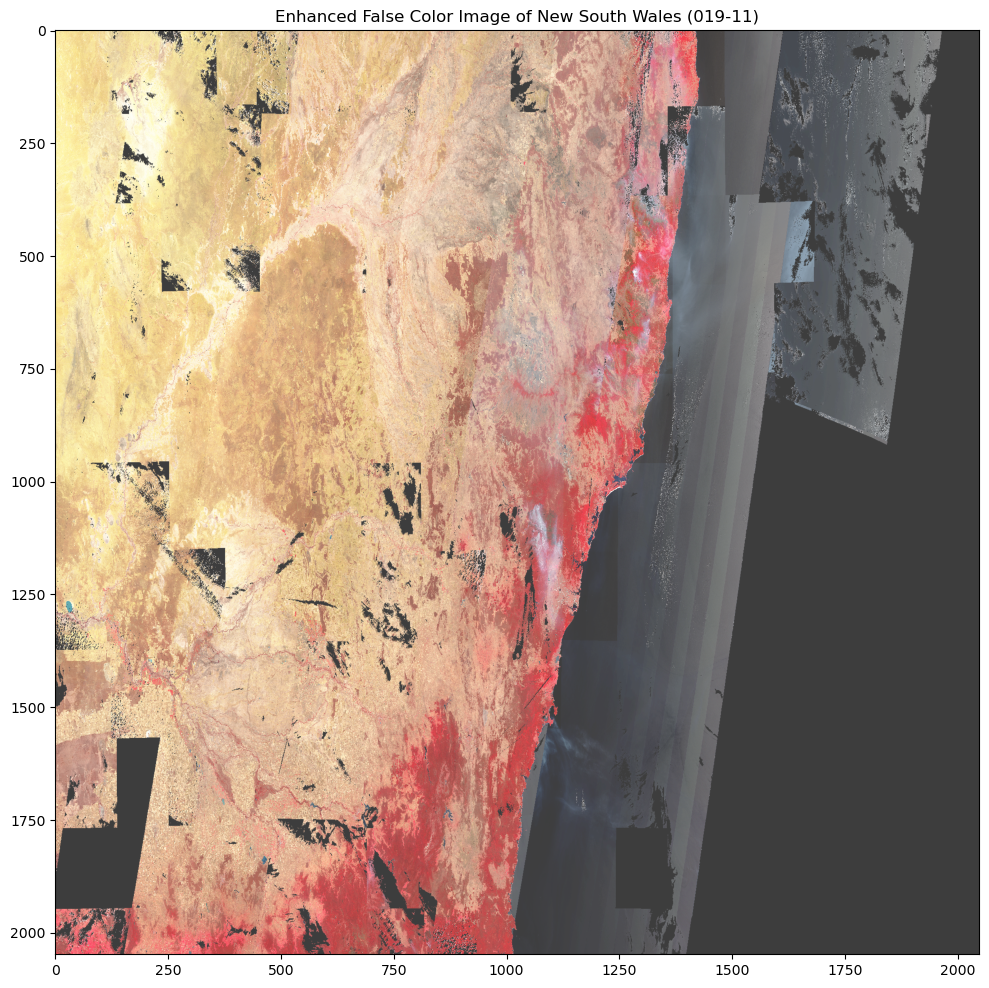

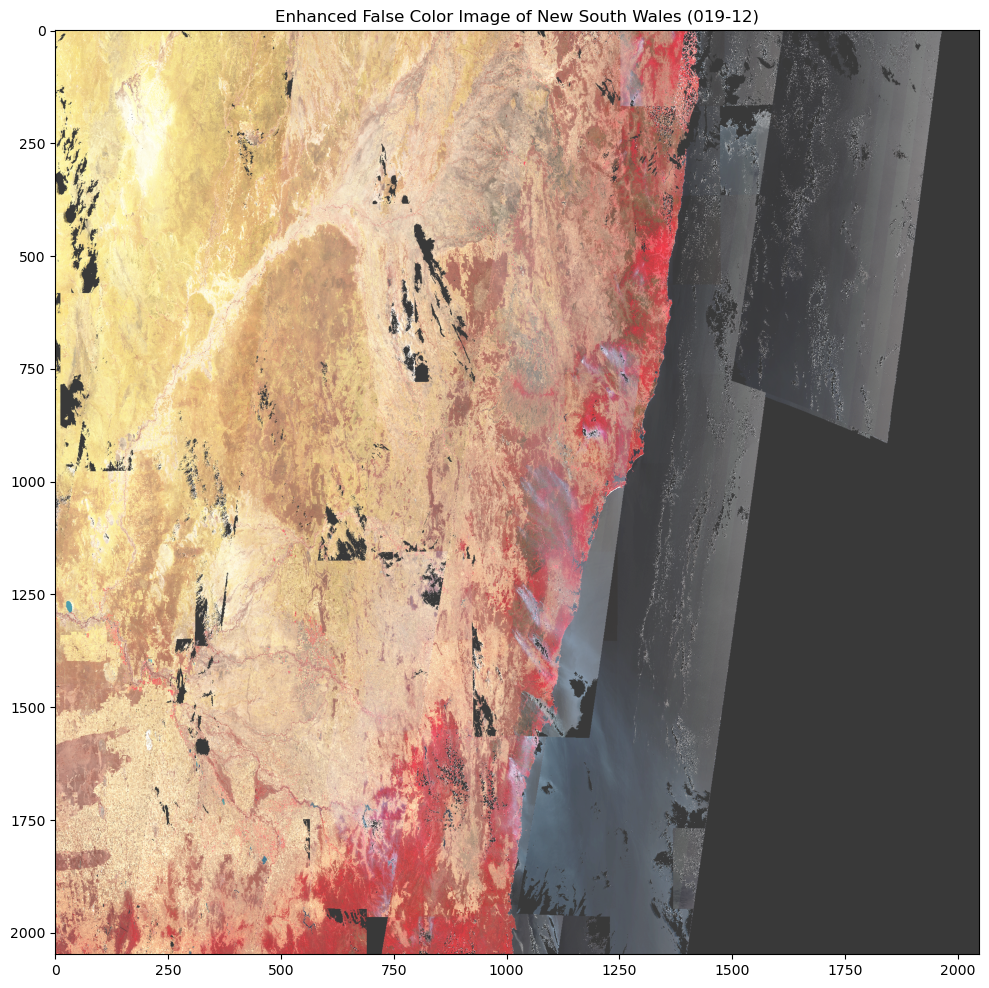

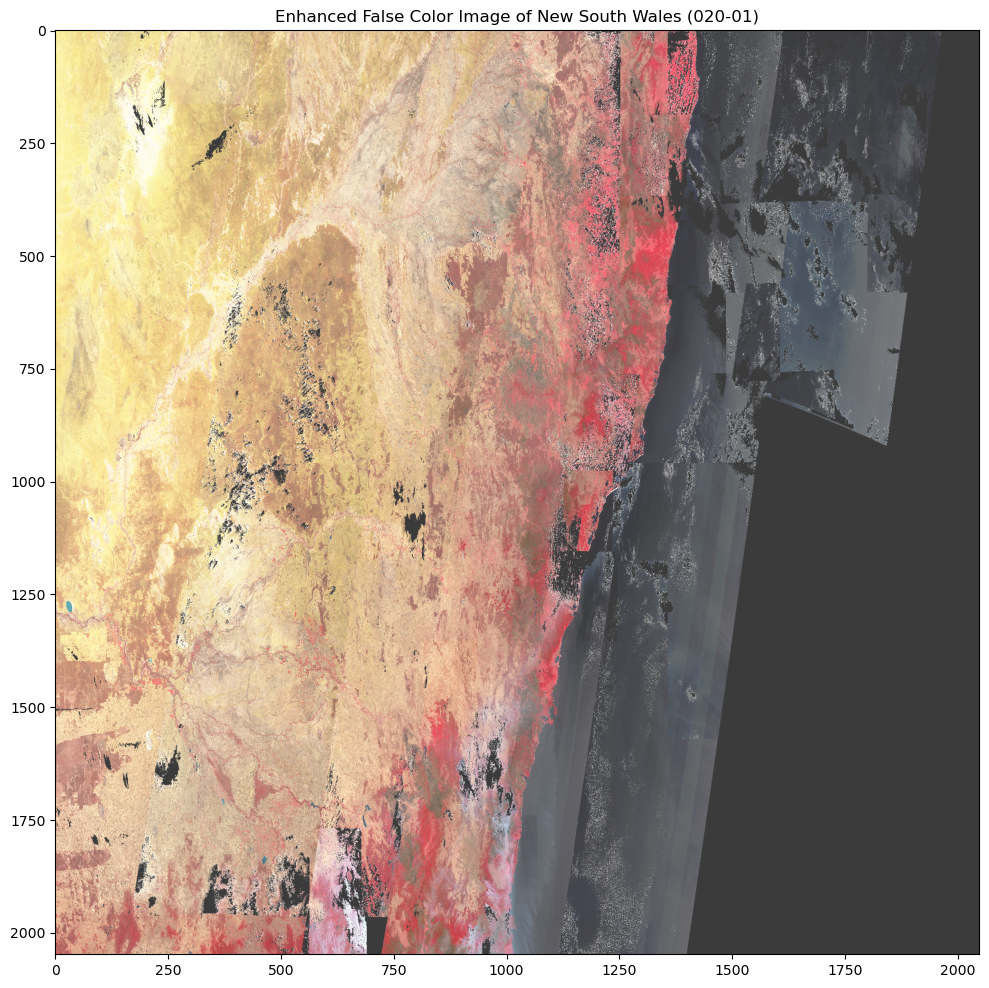

In [42]:
import requests
import json
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

# BBox of New South Wales, Australia
bbox = [140.9993, -37.5050, 159.1056, -28.1570]

# Define the time ranges for each month
time_ranges = [
    ("2019-11-01T00:00:00Z", "2019-11-30T23:59:59Z"),
    ("2019-12-01T00:00:00Z", "2019-12-31T23:59:59Z"),
    ("2020-01-01T00:00:00Z", "2020-01-31T23:59:59Z")
]

# Define the evalscript including cloud filtering
evalscript = """
//VERSION=3
function setup() {
    return {
        input: ["B08", "B04", "B03", "SCL"],
        output: { bands: 4 }
    };
}

function evaluatePixel(sample) {
    if (sample.SCL == 3 || sample.SCL == 8 || sample.SCL == 9 || sample.SCL == 10) {
        // Return transparent for clouds, shadows, and snow
        return [0, 0, 0, 0];
    }
    return [sample.B08, sample.B04, sample.B03, 1];
}
"""

def get_image_for_time_range(start_date, end_date):
    request_body = {
        "input": {
            "bounds": {
                "bbox": bbox
            },
            "data": [
                {
                    "type": "S2L2A",
                    "dataFilter": {
                        "timeRange": {
                            "from": start_date,
                            "to": end_date
                        },
                        "maxCloudCoverage": 20  # Set maximum cloud coverage to 20%
                    }
                }
            ]
        },
        "output": {
            "width": 2048,
            "height": 2048,
            "responses": [
                {
                    "identifier": "default",
                    "format": {
                        "type": "image/tiff"
                    }
                }
            ]
        },
        "evalscript": evalscript
    }

    response = requests.post(
        'https://services.sentinel-hub.com/api/v1/process',
        headers={
            'Authorization': f'Bearer {my_token}',
            'Content-Type': 'application/json'
        },
        data=json.dumps(request_body)
    )

    if response.status_code == 200:
        file_path = f'new_south_wales_{start_date[:7]}.tiff'
        with open(file_path, 'wb') as f:
            f.write(response.content)
        print(f"Image saved as {file_path}")
        return file_path
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        return None

# Get and deak with the images
file_paths = []
for start_date, end_date in time_ranges:
    file_path = get_image_for_time_range(start_date, end_date)
    if file_path:
        file_paths.append(file_path)

# Show and compare the images
for file_path in file_paths:
    with rasterio.open(file_path) as src:
        # Read the red, green, and blue bands
        red = src.read(1)
        green = src.read(2)
        blue = src.read(3)
        
        # Combine the bands into an RGB image
        rgb = np.stack((red, green, blue), axis=-1)
        
        # Enhance the contrast of the image
        rgb_enhanced = exposure.equalize_hist(rgb)

        # Show the image after enhancing the contrast
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.imshow(rgb_enhanced)
        ax.set_title(f"Enhanced False Color Image of New South Wales ({file_path[-11:-5]})")
        plt.show()


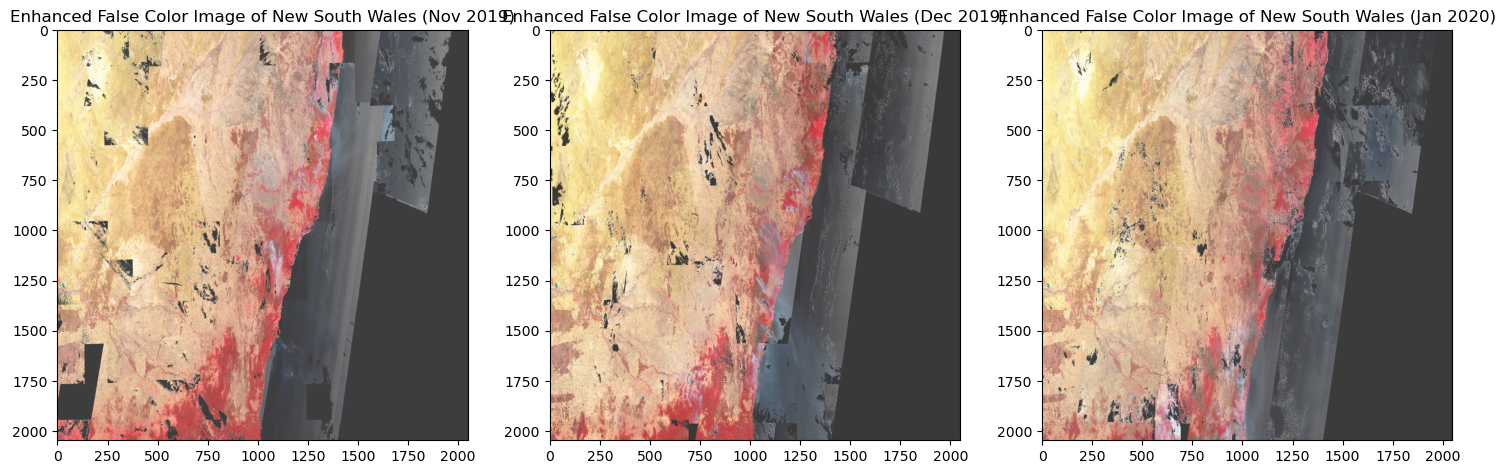

In [47]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

# Reand the tiff images of each month
november_file_path = 'New_South_Wales/new_south_wales_2019-11.tiff'
december_file_path = 'New_South_Wales/new_south_wales_2019-12.tiff'
january_file_path = 'New_South_Wales/new_south_wales_2020-01.tiff'

def read_image(file_path):
    with rasterio.open(file_path) as src:
        # Read the red, green, and blue bands
        red = src.read(1)
        green = src.read(2)
        blue = src.read(3)
        
        # Combine the bands into an RGB image
        rgb = np.stack((red, green, blue), axis=-1)
        
        # Enhance the contrast of the image
        rgb_enhanced = exposure.equalize_hist(rgb)
        
        return rgb_enhanced

# Reand the tiff images of each month
november_image = read_image(november_file_path)
december_image = read_image(december_file_path)
january_image = read_image(january_file_path)

# Show the images side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 12))

axs[0].imshow(november_image)
axs[0].set_title("Enhanced False Color Image of New South Wales (Nov 2019)")

axs[1].imshow(december_image)
axs[1].set_title("Enhanced False Color Image of New South Wales (Dec 2019)")

axs[2].imshow(january_image)
axs[2].set_title("Enhanced False Color Image of New South Wales (Jan 2020)")

plt.show()


/var/folders/06/kgt5sh153k37_v2pww_nnm340000gn/T/ipykernel_12345/1894403281.py:17: RuntimeWarning: divide by zero encountered in divide
  ndvi = (nir - red) / (nir + red)
/var/folders/06/kgt5sh153k37_v2pww_nnm340000gn/T/ipykernel_12345/1894403281.py:17: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


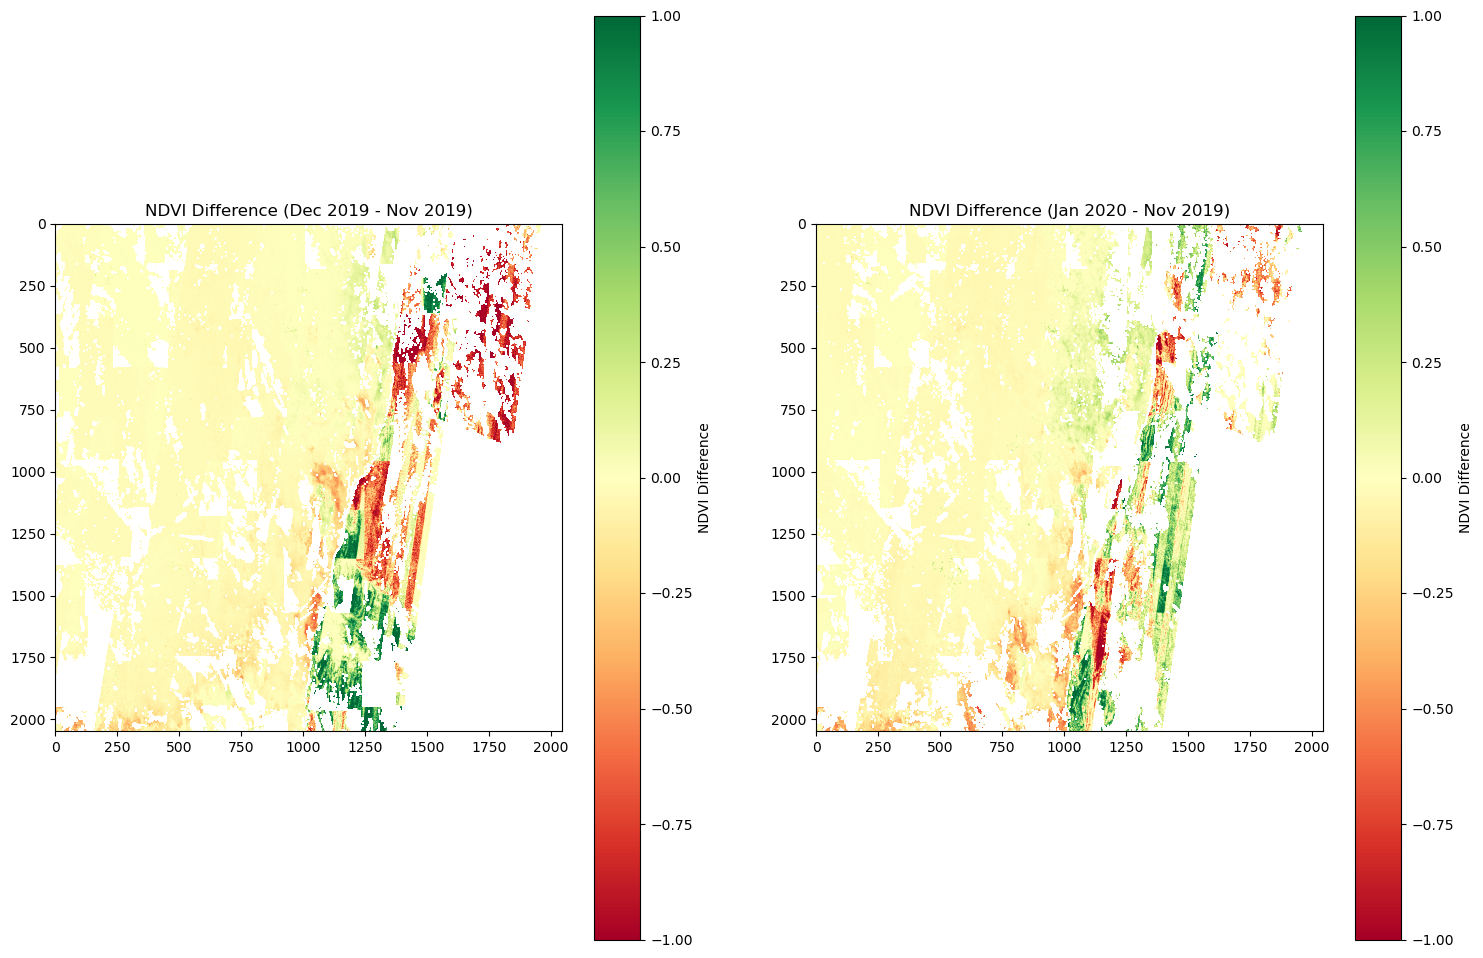

In [44]:
def read_ndvi(file_path):
    with rasterio.open(file_path) as src:
        # Read the NIR and red bands
        nir = src.read(1)
        red = src.read(2)
        
        # Compute the NDVI
        ndvi = (nir - red) / (nir + red)
        return np.clip(ndvi, -1, 1)

# Compute the NDVI for each month
ndvi_november = read_ndvi(november_file_path)
ndvi_december = read_ndvi(december_file_path)
ndvi_january = read_ndvi(january_file_path)

# Compute the NDVI differences
ndvi_diff_dec = ndvi_december - ndvi_november
ndvi_diff_jan = ndvi_january - ndvi_november

# Show the NDVI differences
fig, axs = plt.subplots(1, 2, figsize=(18, 12))

cax1 = axs[0].imshow(ndvi_diff_dec, cmap='RdYlGn', vmin=-1, vmax=1)
axs[0].set_title("NDVI Difference (Dec 2019 - Nov 2019)")
fig.colorbar(cax1, ax=axs[0], orientation='vertical', label='NDVI Difference')

cax2 = axs[1].imshow(ndvi_diff_jan, cmap='RdYlGn', vmin=-1, vmax=1)
axs[1].set_title("NDVI Difference (Jan 2020 - Nov 2019)")
fig.colorbar(cax2, ax=axs[1], orientation='vertical', label='NDVI Difference')

plt.show()
